In [15]:
%pip install sdv sklearn


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

In [16]:
import pandas as pd
from sdv.single_table import TVAESynthesizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sdv.metadata import Metadata


# Load your data
data = pd.read_csv('diabetes.csv')

# Preprocess the data (for example, standardize numeric features)
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Separate categorical columns (if any)
categorical_columns = data.select_dtypes(include=['object']).columns

**TVAE Model**

TVAE is part of the SDV (Synthetic Data Vault) library and is built on the concept of a Variational Autoencoder (VAE). It's designed to learn the distribution of your real dataset and generate new, realistic synthetic samples. It Handle mixed data types (numerical + categorical).

TVAE consists of two main parts:

Encoder – Compresses the input data into a latent vector (a compact representation).
Decoder – Reconstructs the original data from the latent vector.

During training, the model:

Learns to reconstruct the input data from the latent space
Also learns a distribution (mean and variance) over the latent space, which helps in sampling new synthetic data

In [17]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

metadata = Metadata.detect_from_dataframe(
    data=data,
    table_name='diabetes')

tvae_model = TVAESynthesizer(
    metadata, # required
    enforce_min_max_values=True,
    enforce_rounding=False,
    epochs=350
)

tvae_model.fit(X_train)



c:\Users\lenovo\Desktop\minor-project\streamlit-venv\Lib\site-packages\sdv\single_table\base.py:105: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.



In [18]:
tvae_model.get_loss_values()

,Epoch,Batch,Loss
0,0,0,35.984421
1,0,1,35.263355
2,1,0,31.845999
3,1,1,30.685356
4,2,0,29.864998
...,...,...,...
695,347,1,-5.187449
696,348,0,-5.813141
697,348,1,-5.122902
698,349,0,-5.640264


In [19]:
synthetic_data = tvae_model.sample(1000)
print(synthetic_data.head())

   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0    -0.787908 -0.672792       0.586365       0.527719 -0.185713 -0.167864   
1    -0.774192 -0.805015       0.604610       0.072494 -0.685324 -1.045224   
2    -1.141852 -1.086084      -0.366089       1.050370 -0.692891 -0.783334   
3    -0.976934 -0.634784       0.519630       1.149067 -0.692891 -0.834597   
4     1.045113  0.306220       0.073657       0.187159 -0.660873  0.445735   

   DiabetesPedigreeFunction       Age   Outcome  
0                  0.976326  0.925531 -0.723421  
1                 -0.651756 -0.901704 -0.732120  
2                 -0.867259 -1.041549 -0.732120  
3                 -0.841023 -1.041549 -0.727154  
4                 -1.005457  1.892066  1.364817  


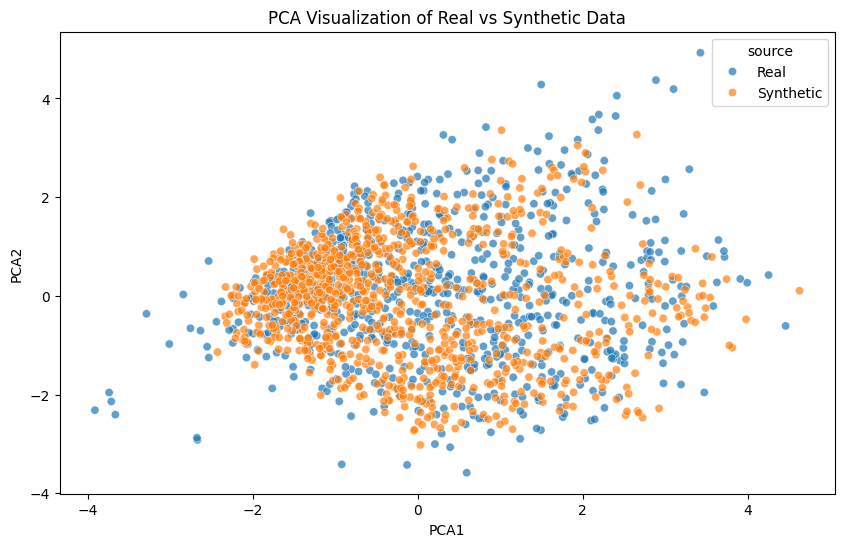

In [20]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Combine data
data['source'] = 'Real'
synthetic_data['source'] = 'Synthetic'

combined = pd.concat([data, synthetic_data])

# Drop 'Outcome' if needed
features = combined.drop(['source'], axis=1)

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

combined['PCA1'] = pca_result[:,0]
combined['PCA2'] = pca_result[:,1]

# Plot
plt.figure(figsize=(10,6))
sns.scatterplot(data=combined, x='PCA1', y='PCA2', hue='source', alpha=0.7)
plt.title('PCA Visualization of Real vs Synthetic Data')
plt.show()


In [21]:
from sdmetrics.reports.single_table import QualityReport
from sdmetrics.reports.single_table import DiagnosticReport

metadata_dict = metadata.to_dict()
metadata_dict = metadata_dict['tables']['diabetes']
report = QualityReport()
# Drop 'source' column from synthetic_data if it exists'ArithmeticError

if 'source' in synthetic_data.columns:
    synthetic_data = synthetic_data.drop(columns='source')

if 'source' in data.columns:
    data = data.drop(columns='source')

report.generate(data,synthetic_data,metadata_dict)

# View overall score
report.get_score()

# Detailed breakdown
# report.get_details('Column Shapes')
# report.get_details('Column Pair Trends')

diagnostic = DiagnosticReport()
diagnostic.generate(data, synthetic_data, metadata_dict)

# Summary
diagnostic.get_score()

# Details
# diagnostic.get_details('Data Validity')
# diagnostic.get_details('Data Structure')


Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 9/9 [00:00<00:00, 283.31it/s]|
Column Shapes Score: 80.66%

(2/2) Evaluating Column Pair Trends: |██████████| 36/36 [00:00<00:00, 294.23it/s]|
Column Pair Trends Score: 96.6%

Overall Score (Average): 88.63%

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 9/9 [00:00<00:00, 1549.17it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 438.64it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



np.float64(1.0)

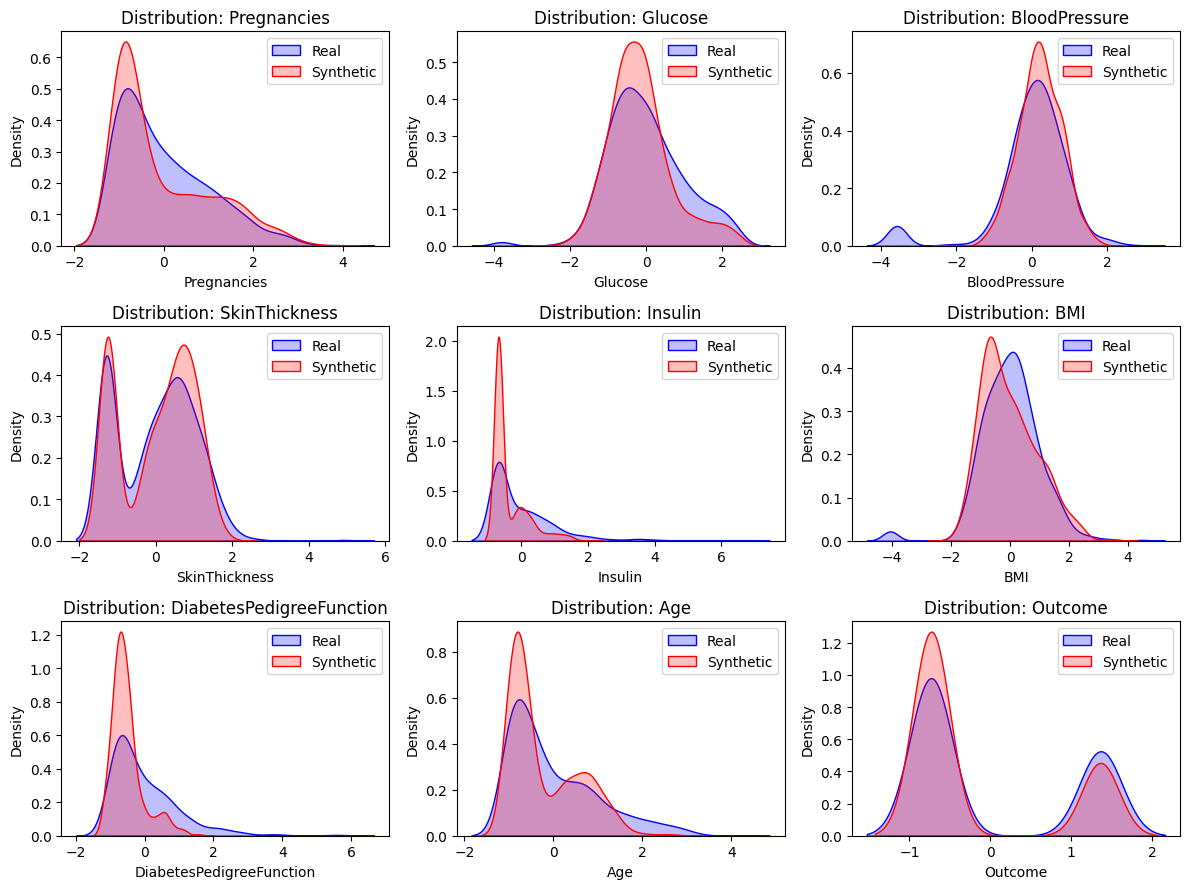

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Filter numeric columns
numeric_columns = data.select_dtypes(include=['number']).columns

# Drop 'source' column from synthetic_data if it exists
if 'source' in synthetic_data.columns:
    synthetic_data = synthetic_data.drop(columns='source')

# Layout: 3 plots per row (adjust as needed)
cols_per_row = 3
total_plots = len(numeric_columns)
rows = math.ceil(total_plots / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 4, rows * 3))
axes = axes.flatten()  # Flatten in case of multiple rows

for i, col in enumerate(numeric_columns):
    ax = axes[i]
    sns.kdeplot(data[col], label='Real', fill=True, color='blue', ax=ax)
    sns.kdeplot(synthetic_data[col], label='Synthetic', fill=True, color='red', ax=ax)
    ax.set_title(f'Distribution: {col}')
    ax.legend()

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


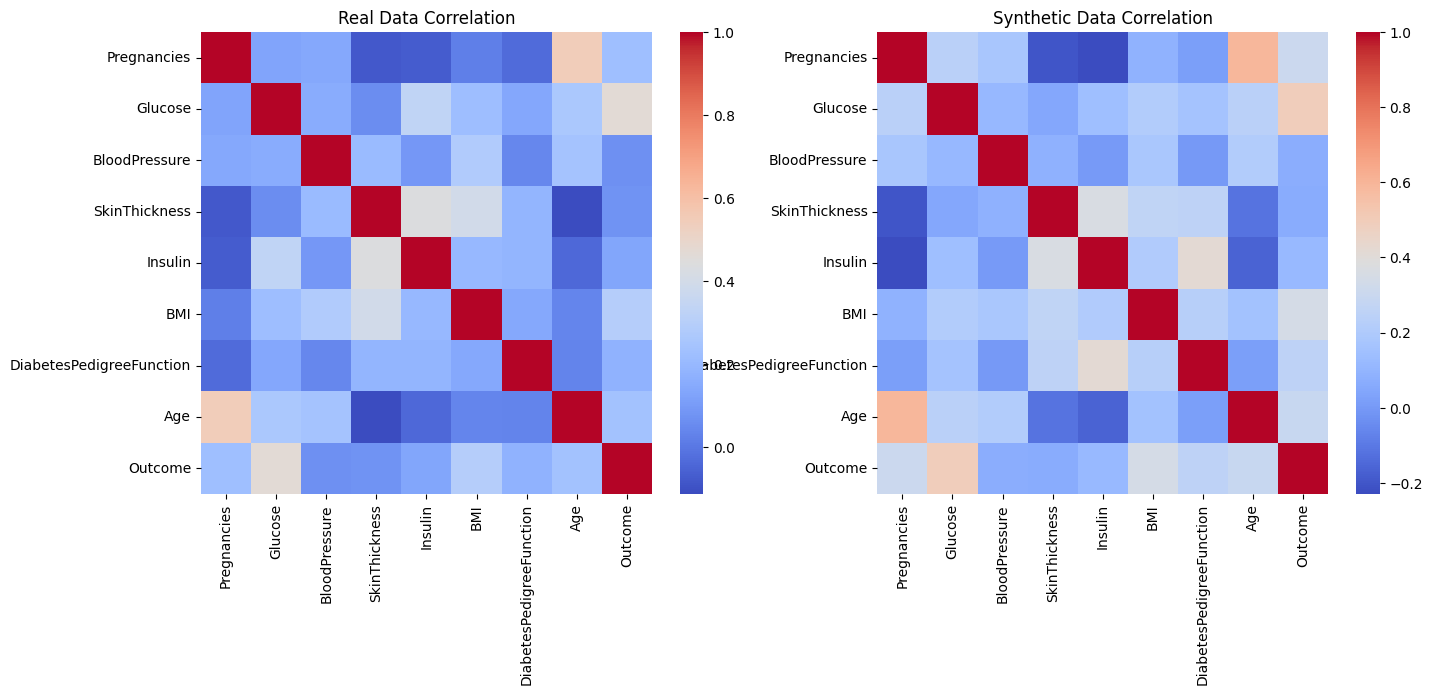

Mean Absolute Correlation Difference: 0.0680


In [23]:
import numpy as np
import pandas as pd

# Correlation matrices
if 'source' in data.columns:
    data = data.drop(columns='source')

real_corr = data.corr()
synthetic_corr = synthetic_data.corr()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(real_corr, ax=axes[0], cmap="coolwarm", annot=False)
axes[0].set_title('Real Data Correlation')

sns.heatmap(synthetic_corr, ax=axes[1], cmap="coolwarm", annot=False)
axes[1].set_title('Synthetic Data Correlation')

plt.show()
# Mean Absolute Error between correlation matrices
correlation_diff = np.abs(real_corr - synthetic_corr)
mean_diff = correlation_diff.values[np.triu_indices_from(correlation_diff, k=1)].mean()

print(f"Mean Absolute Correlation Difference: {mean_diff:.4f}")


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# Prepare training data
X_synthetic = synthetic_data.drop(columns=['Outcome'])
y_synthetic = synthetic_data['Outcome'].round().astype(int)  # Fix here

# Train classifier
clf = RandomForestClassifier()
clf.fit(X_synthetic, y_synthetic)

# Prepare test data
X_real = X_test.drop(columns=['Outcome'])
y_real = X_test['Outcome'].round().astype(int)  # Fix here
y_pred = clf.predict(X_real)

# Evaluate performance
accuracy = accuracy_score(y_real, y_pred)
f1 = f1_score(y_real, y_pred)

print(f'Accuracy on Real Data: {accuracy:.2%}')
print(f'F1 Score on Real Data: {f1:.2%}')


Accuracy on Real Data: 76.62%
F1 Score on Real Data: 67.86%


In [25]:
from scipy.stats import ks_2samp

for col in numeric_columns:
    stat, p = ks_2samp(data[col], synthetic_data[col])
    print(f'{col}: KS-stat={stat:.3f}, p-value={p:.3f}')


Pregnancies: KS-stat=0.185, p-value=0.000
Glucose: KS-stat=0.122, p-value=0.000
BloodPressure: KS-stat=0.114, p-value=0.000
SkinThickness: KS-stat=0.141, p-value=0.000
Insulin: KS-stat=0.196, p-value=0.000
BMI: KS-stat=0.115, p-value=0.000
DiabetesPedigreeFunction: KS-stat=0.303, p-value=0.000
Age: KS-stat=0.150, p-value=0.000
Outcome: KS-stat=0.415, p-value=0.000


In [26]:
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdv.evaluation.single_table import get_column_plot

# 1. perform basic validity checks
diagnostic = run_diagnostic(data, synthetic_data, metadata)

# 2. measure the statistical similarity
quality_report = evaluate_quality(data, synthetic_data, metadata)
print(diagnostic.get_details(property_name='Data Structure'))
# 3. plot the data
fig = get_column_plot(
    real_data=data,
    synthetic_data=synthetic_data,
    metadata=metadata,
    column_name='Outcome'
)
    
plt.show()

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 9/9 [00:00<00:00, 1642.46it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 558.87it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 9/9 [00:00<00:00, 454.17it/s]|
Column Shapes Score: 80.66%

(2/2) Evaluating Column Pair Trends: |██████████| 36/36 [00:00<00:00, 238.29it/s]|
Column Pair Trends Score: 96.6%

Overall Score (Average): 88.63%

           Metric  Score
0  TableStructure    1.0


In [27]:
quality_report.get_details(property_name='Column Shapes')

,Column,Metric,Score
0,Pregnancies,KSComplement,0.815312
1,Glucose,KSComplement,0.877729
2,BloodPressure,KSComplement,0.885938
3,SkinThickness,KSComplement,0.859427
4,Insulin,KSComplement,0.803979
5,BMI,KSComplement,0.884865
6,DiabetesPedigreeFunction,KSComplement,0.696625
7,Age,KSComplement,0.850292
8,Outcome,KSComplement,0.584958


In [ ]:
tvae_model.save('tvae_synth.pkl')